# Lecture 2: Spark Dataframes

Spark SQL is a module that can be used to process structured data, e.g organized in columns. Spark Dataframes relies on RDD, but provides richer optimizations under the hoods.


As for the previous lecture, select the most appropriate variable based on where this notebook is run. If the docker cluster is used, the process of starting spark cluster can be skipped.

In [1]:
# set this variable with one of the following values
# -> 'local'
# -> 'docker_container'
# -> 'docker_cluster'
CLUSTER_TYPE ='docker_container'

In [2]:
# set env variable
%env CLUSTER_TYPE $CLUSTER_TYPE

env: CLUSTER_TYPE=docker_container


## Start the cluster 

Environment variables need to be set only in the case of a local cluster

In [ ]:
if CLUSTER_TYPE=='local':
    import findspark
    findspark.init('/Users/matteo/Work/MAPD/spark-3.1.1-bin-hadoop3.2/')

In [3]:
%%script bash --no-raise-error

if [[ "$CLUSTER_TYPE" != "docker_cluster" ]]; then
    echo "Launching master and worker"
    
    # start master 
    $SPARK_HOME/sbin/start-master.sh --host localhost \
        --port 7077 --webui-port 8080
    
    # start worker
    $SPARK_HOME/sbin/start-worker.sh spark://localhost:7077 \
        --cores 2 --memory 2g
fi

Launching master and worker
starting org.apache.spark.deploy.master.Master, logging to /usr/bin/spark-3.1.1-bin-hadoop3.2/logs/spark--org.apache.spark.deploy.master.Master-1-065dcfffd35d.out
starting org.apache.spark.deploy.worker.Worker, logging to /usr/bin/spark-3.1.1-bin-hadoop3.2/logs/spark--org.apache.spark.deploy.worker.Worker-1-065dcfffd35d.out


## Create the Spark session

Later on we will explain what is the role of [Apache Arrow](), but first we need to install it and create the spark session with it.

In [4]:
!pip install pyarrow

In [5]:
from pyspark.sql import SparkSession

if CLUSTER_TYPE in ['local', 'docker_container']:
    
    spark = SparkSession.builder \
        .master("spark://localhost:7077")\
        .appName("First spark application")\
        .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
        .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false")\
        .getOrCreate()

elif CLUSTER_TYPE == 'docker_cluster':
    
    # use the provided master
    spark = SparkSession.builder \
        .master("spark://spark-master:7077")\
        .appName("First spark application")\
        .config("spark.executor.memory", "512m")\
        .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
        .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false")\
        .getOrCreate()
    
spark

In [6]:
sc = spark.sparkContext
sc

<SparkContext master=spark://localhost:7077 appName=First spark application>

### Load data

By default Spark can create a dataframe from data stored in many formats such as `csv`, `json` and many other listed [here](https://spark.apache.org/docs/latest/sql-data-sources-load-save-functions.html). 

If your dataset is stored in a format that spark cannot understand, it is always possible to create a dataframe from an RDD.

In [9]:
from pyspark.sql.types import Row
import numpy as np

def read_custom_data(file_name):
    # pretend to load some real data
    custom_data = []
    for i in range(5):
        event = {
            'feature1': np.random.random(),
            'feature2': np.random.random()
        }
        custom_data.append(Row(**event))
    return custom_data
    
# read some files in parallel and create a dataframe
file_list = ['file1', 'file2']

df = sc.parallelize(file_list)\
    .flatMap(read_custom_data)\
    .toDF()

In [10]:
df.show(5)

+-------------------+-------------------+
|           feature1|           feature2|
+-------------------+-------------------+
|0.03884918059455267|  0.962825901442956|
| 0.8407823035414668| 0.1053929710391136|
| 0.9354018221548657| 0.3017664022996871|
| 0.9166560033319637|0.17741412037069904|
| 0.9055269137557943|0.19427004657210156|
+-------------------+-------------------+
only showing top 5 rows



## Dimuon

Several particles decay in a pair of opposite charged leptons (electrons, muons and taus).
The dimuon spectrum, computed by calculating the invariant mass of muon pairs with opposite charge, features the presence of a number of narrow resonances, corresponding to the mass of the parent particle: from the η meson at about 548 MeV  up to the Z boson at about 91 GeV.
Rare processes are also associated to this very same final state, such as the Bs dimuon decay (first observed in 2012 at CMS and LHCb), and the elusive Higgs dimuon decay (for which there is statistical evidence, but not yet an observation); new yet undiscovered particles might also show up as new resonances in the dimuon spectrum as the statistics and accelerator energy is increased.

![Event Display](imgs/lecture2/event_display.png)

The dataset used in this exercise is taken from the CERN Open Data portal (https://opendata.cern.ch/) and represents a portion of the data collected by the CMS collaboration at the Large Hadron Collider in 2010.
This dataset comprise of only the fraction of events retained by online selections (trigger) which identify collisions where muons have been produced, thus storing only about 10 events out of the about 40 millions of collisions produced every second at LHC.
The whole dataset collected by the CMS collaboration since the start of LHC operations in 2010 is comprised of tens of PBs of data and simulations.


A subset of events have been extracted and preprocessed since original data are stored in ROOT files containing. The result is stored as JSON files.

In [12]:
# load dataset on dataset/lecture2/dimuon
df = spark.read.format('json') \
    .load('../datasets/lecture2/dimuon/*.json')

In [13]:
# dataset schema
df.printSchema()

root
 |-- Muons: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- E: double (nullable = true)
 |    |    |-- charge: long (nullable = true)
 |    |    |-- px: double (nullable = true)
 |    |    |-- py: double (nullable = true)
 |    |    |-- pz: double (nullable = true)
 |-- nMuon: long (nullable = true)
 |-- sample: string (nullable = true)



In [15]:
# show first rows
df.show(5)

+--------------------+-----+------+
|               Muons|nMuon|sample|
+--------------------+-----+------+
|[{17.492634165117...|    2|  data|
|[{11.518019014184...|    2|  data|
|[{15.121118467960...|    1|  data|
|[{29.141155937086...|    4|  data|
|[{14.601779359675...|    4|  data|
+--------------------+-----+------+
only showing top 5 rows



As we will see in the next cells, the API used to interact with spark dataframes is very similar to Pandas

**Note**: [Koalas](https://github.com/databricks/koalas) aims at replicating 1 to 1 the pandas API in Apache Spark. This package will be included by default in the next version of Spark (Spark 3.2). However, what we will se today are the core concepts of pyspark's dataframes and will remain mandatory to work with it. 

In [16]:
# count the number of events per each sample
df.groupBy('sample').count().show()

+------+-----+
|sample|count|
+------+-----+
|    mc|25000|
|  data|25000|
+------+-----+



In [17]:
# persist the dataframe to avoid
# loading it every time
df = df.persist()
df.count()

50000

In [18]:
# get the number of muons
# distribution and plot it
num_muons_dist = df.groupBy('sample', 'nMuon')\
    .count() \
    .sort('nMuon')\
    .collect()

In [19]:
num_muons_dist[:5]

[Row(sample='data', nMuon=0, count=673),
 Row(sample='mc', nMuon=0, count=914),
 Row(sample='mc', nMuon=1, count=3578),
 Row(sample='data', nMuon=1, count=3118),
 Row(sample='mc', nMuon=2, count=11930)]

Plotting this data would require a lot of code, but fortunately there is a magic trick we can use: it is possible to convert a spark dataframe into a  Pandas Dataframe with `toPandas()`. Again, as it happens for `collect()`, the entire dataset is fetched into the master and it may not fit in the memory.

**Apache Arrow** comes into play in this contex: it is an in-memory columnar data format that is used in spark to efficiently transfer data between the JVM and Python processes. When it is not enabled Spark comunicates with python processes by serializing and deserializing one element of the time. With Arrow this operation is "vectorized", i.e. one column at the time is transfered. This is possible because both spark and pandas included Arrow representation.

[Here](https://xuechendi.github.io/2019/04/16/Apache-Arrow) you can find a nice blog post explaining how it works.

In this way, operations between Pyspark and Pandas are more efficient and we can try to get the best from both worlds. 

In [21]:
import pandas as pd

# punt the results into a pandas dataframe
num_muons_dist = df.groupBy('sample', 'nMuon')\
    .count()\
    .sort('nMuon') \
    .toPandas()

num_muons_dist.head()

,sample,nMuon,count
0,data,0,673
1,mc,0,914
2,mc,1,3578
3,data,1,3118
4,mc,2,11930


In [22]:
# type of this dataset
type(num_muons_dist)

pandas.core.frame.DataFrame

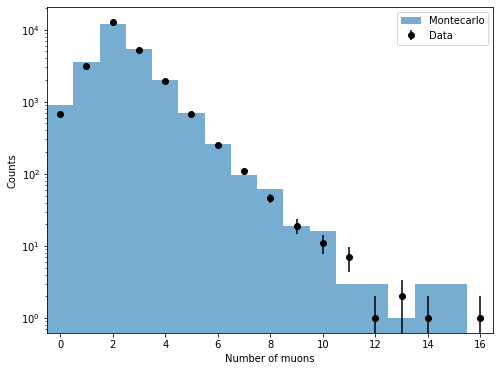

In [23]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8,6))
mc_counts = num_muons_dist.loc[num_muons_dist['sample']=='mc']
plt.bar(
    mc_counts['nMuon'], mc_counts['count'],
    label = 'Montecarlo', width=1, alpha=0.6
)

data_counts = num_muons_dist.loc[num_muons_dist['sample']=='data']
plt.errorbar(
    data_counts['nMuon'],data_counts['count'],
    yerr = np.sqrt(data_counts['count']),
    label = 'Data', color='black', fmt='o'
)
plt.xlim(-0.5,16.5)
plt.xlabel("Number of muons")
plt.ylabel("Counts")
plt.legend()
plt.semilogy()
plt.show()

We are interested in dimuon events, i.e. events having 2 muons. We can do this with `filter` or `where`

In [24]:
# select only events with two muons
dimuon_df = df.where(df['nMuon']==2)
dimuon_df.show(5)

+--------------------+-----+------+
|               Muons|nMuon|sample|
+--------------------+-----+------+
|[{17.492634165117...|    2|  data|
|[{11.518019014184...|    2|  data|
|[{65.955784364436...|    2|  data|
|[{14.860828916586...|    2|  data|
|[{11.205213649577...|    2|  data|
+--------------------+-----+------+
only showing top 5 rows



In [27]:
from pyspark.sql.functions import col

# possible to perform the same selection in multiple ways
df.where(col('nMuon')==2).show(5)
df.where("nMuon == 2").show(5)
df.filter('(nMuon > 2) AND (nMuon < 5)').show(5)

+--------------------+-----+------+
|               Muons|nMuon|sample|
+--------------------+-----+------+
|[{17.492634165117...|    2|  data|
|[{11.518019014184...|    2|  data|
|[{65.955784364436...|    2|  data|
|[{14.860828916586...|    2|  data|
|[{11.205213649577...|    2|  data|
+--------------------+-----+------+
only showing top 5 rows

+--------------------+-----+------+
|               Muons|nMuon|sample|
+--------------------+-----+------+
|[{17.492634165117...|    2|  data|
|[{11.518019014184...|    2|  data|
|[{65.955784364436...|    2|  data|
|[{14.860828916586...|    2|  data|
|[{11.205213649577...|    2|  data|
+--------------------+-----+------+
only showing top 5 rows

+--------------------+-----+------+
|               Muons|nMuon|sample|
+--------------------+-----+------+
|[{29.141155937086...|    4|  data|
|[{14.601779359675...|    4|  data|
|[{7.4843520373597...|    3|  data|
|[{46.087708089298...|    3|  data|
|[{76.741127471713...|    3|  data|
+-------------

In [28]:
# dataset is not flat
dimuon_df.printSchema()

root
 |-- Muons: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- E: double (nullable = true)
 |    |    |-- charge: long (nullable = true)
 |    |    |-- px: double (nullable = true)
 |    |    |-- py: double (nullable = true)
 |    |    |-- pz: double (nullable = true)
 |-- nMuon: long (nullable = true)
 |-- sample: string (nullable = true)



Now we can make our dataset flat for further processing: in this way we will be able to perform operations between the columns.

A new column can be created by using `withColumn(name, func)` where `func` is a function taking as input one or more columns. An arbitrary complex function can be used to produce the new column: for example we can define a User Defined Function (UDF) which will be applied to every row of the dataframe. 

In [39]:
# create columns for the two muons
dimuon_flat = (
    dimuon_df.select([col('sample'), col('nMuon'), col('Muons')[0], col('Muons')[1]])
    .withColumn('E1', col('Muons[0].E'))
    .withColumn('px1', col('Muons[0].px'))
    .withColumn('py1', col('Muons[0].py'))
    .withColumn('pz1', col('Muons[0].pz'))
    .withColumn('c1',  col('Muons[0].charge'))
    .withColumn('E2',  col('Muons[1].E'))
    .withColumn('px2', col('Muons[1].px'))
    .withColumn('py2', col('Muons[1].py'))
    .withColumn('pz2', col('Muons[1].pz'))
    .withColumn('c2',  col('Muons[1].charge'))
    .drop('Muons[0]', 'Muons[1]')
)

dimuon_flat.printSchema()

root
 |-- sample: string (nullable = true)
 |-- nMuon: long (nullable = true)
 |-- E1: double (nullable = true)
 |-- px1: double (nullable = true)
 |-- py1: double (nullable = true)
 |-- pz1: double (nullable = true)
 |-- c1: long (nullable = true)
 |-- E2: double (nullable = true)
 |-- px2: double (nullable = true)
 |-- py2: double (nullable = true)
 |-- pz2: double (nullable = true)
 |-- c2: long (nullable = true)



We can now continue with our work and select only the events where the two muons have opposite charge (column `c1` and `c2`)

In [40]:
# select candidates with opposit charge
dimuon_flat = dimuon_flat.where(col('c1')!=col('c2'))
dimuon_flat.count()

18827

In [41]:
dimuon_flat.write.parquet("dimuon_flat.parquet")

To compute the invariant mass of the two candidate muons we need first to compute the four-momentum of the parent particle 

$$
p = \left(E_1+E_2,\quad p_{x,1}+p_{x,2},\quad p_{y,1}+p_{y,2},\quad p_{z,1}+p_{z,2}\right) = (E,\, \mathbf{p})
$$

Create four new columns in the dataframe, one per each coordinate

In [ ]:
# create new columns for the four momentum


From the 4-momentum of the candidate we can compute the invariant mass as

$$
M = \sqrt{p\cdot p} =  \sqrt{(E^2 - \|\mathbf{p}\|^2)} = \sqrt{(E^2 - (px^2 + py^2 + pz^2)}
$$

In [ ]:
# compute invariant mass


It is possible to obtain the same result using a UDF

In [ ]:
from pyspark.sql.functions import udf
import math

# obtain the same result using udf


Similarly, we can use pandas UDF. This allows to process pyspark's dataframes as pandas dataframes and pandas series.
They result particularly efficient in the groupped maps, i.e. by appling a function after a groupby. More on this can be found [here](https://spark.apache.org/docs/latest/api/python/user_guide/arrow_pandas.html#grouped-map). 

In [ ]:
from pyspark.sql.functions import pandas_udf


Computer the mean energy for different groups

In [ ]:
# compute mean energy for each sample

### Discovering particles

Now that all the interesting quantities have been computed we can use them to perform the analysis.

For example, let's plot the invariant mass of the dimuon system.

In [ ]:
# compute the histogram of M

In [ ]:
# compute it for each sample
histogram_results = {}
for sample in ['mc', 'data']:
    histogram_results[sample] = {}
    
    

In [ ]:
plt.figure(figsize=(8,6))

mc_res = histogram_results['mc']
bin_centers = mc_res['bins'][:-1] + np.diff(mc_res['bins'])/2
plt.hist(
    bin_centers, weights=mc_res['counts'], bins=mc_res['bins'],
    label='Montecarlo', alpha=0.6
)

data_res = histogram_results['data']
bin_centers = data_res['bins'][:-1] + np.diff(data_res['bins'])/2

plt.errorbar(
    bin_centers, data_res['counts'], yerr=np.sqrt(data_res['counts']),
    fmt='o', ms=4, lw=1, color='black', label='data'
)

plt.xlabel("$m_{\mu \mu}$ [GeV]")
plt.ylabel("Events/0.5GeV")
plt.legend()
plt.semilogy()
plt.tight_layout()
plt.show()

In the range 80-100 GeV it appears there is a large resonance, we can histogram the data in that range to see it better.

In [ ]:
histogram_results = {}
for sample in ['mc', 'data']:
    histogram_results[sample] = {}
    
    bins, counts = (
        dimuon_flat.where(col('sample')==sample)
        .select('M')
        .rdd.map(lambda x: x['M'])
        .histogram(list(np.arange(70,115,0.5)))
    )
    
    histogram_results[sample]['bins'] = bins
    histogram_results[sample]['counts'] = counts
    
plt.figure(figsize=(8,6))

mc_res = histogram_results['mc']
bin_centers = mc_res['bins'][:-1] + np.diff(mc_res['bins'])/2
plt.hist(
    bin_centers, weights=mc_res['counts'], bins=mc_res['bins'],
    label='Montecarlo', alpha=0.6
)

data_res = histogram_results['data']
bin_centers = data_res['bins'][:-1] + np.diff(data_res['bins'])/2

plt.errorbar(
    bin_centers, data_res['counts'], yerr=np.sqrt(data_res['counts']),
    fmt='o', ms=4, lw=1, color='black', label='data'
)

plt.xlabel("$m_{\mu \mu}$ [GeV]")
plt.ylabel("Events/0.5GeV")
plt.legend()
#plt.semilogy()
plt.tight_layout()
plt.show()

We can try to perform some selection, to improve the quality of the signal and remove background. To do this we can try look at candidates with a large transverse momentum 

$$
p_T = \sqrt{p_x^2 + p_y^2}
$$

create a colum with name "energetic" and for each row set the value to `True` if $p_T\geq 30$ Gev. Plot then the results and see if there is any improvement. You can compare just the data or montecarlo. 

This can be achieved in spark using `when()` and `otherwise()`.

In [ ]:
from pyspark.sql.functions import when



In [ ]:
def compute_histogram(dataset, column):
    histogram_results = {}
    for sample in ['mc', 'data']:
        histogram_results[sample] = {}

        bins, counts = (
            dataset.where(col('sample')==sample)
            .select(column)
            .rdd.map(lambda x: x[column])
            .histogram(list(np.arange(70,115,0.5)))
        )

        histogram_results[sample]['bins'] = bins
        histogram_results[sample]['counts'] = counts
        
    return histogram_results
        

is_energetic = compute_histogram(dimuon_flat.where(col('highpt')==True), 'M')
not_energetic = compute_histogram(dimuon_flat.where(col('highpt')==False), 'M')
 
plt.figure(figsize=(8,6))

mc_res = not_energetic['mc']
bin_centers = mc_res['bins'][:-1] + np.diff(mc_res['bins'])/2
plt.hist(
    bin_centers, weights=mc_res['counts'], bins=mc_res['bins'],
    label='Not energetic', alpha=0.6
)

mc_res = is_energetic['mc']
bin_centers = mc_res['bins'][:-1] + np.diff(mc_res['bins'])/2
plt.hist(
    bin_centers, weights=mc_res['counts'], bins=mc_res['bins'],
    label='Energetic', alpha=0.6
)

plt.xlabel("$m_{\mu \mu}$ [GeV]")
plt.ylabel("Events/0.5GeV")
plt.legend()
#plt.semilogy()
plt.tight_layout()
plt.show()

## Stop worker and master

In [ ]:
sc.stop()
spark.stop()

In [ ]:
%%script bash --no-raise-error

if [[ "$CLUSTER_TYPE" != "docker_cluster" ]]; then
    # stop worker 
    $SPARK_HOME/sbin/stop-worker.sh
    
    # start master
    $SPARK_HOME/sbin/stop-master.sh
fi